In [73]:
import asyncio
import collections
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from docx import Document
from rpy2.robjects import r, pandas2ri

import sys
sys.path.append("../")

import importlib
import llm_models
importlib.reload(llm_models)

from llm_models.utils import setup_transmission_chain
from llm_models.tasks import TaskFactory
from llm_models.enums import TaskType, AzureOpenAIModelType
from llm_models.node import Node
from llm_models.openai_model import AzureOpenAIModel

study_data = Path("../llm_models/study-data/").resolve()


POSITIVE = "POSITIVE:"
NEGATIVE = "NEGATIVE:"
AMBIGUOUS = "AMBIGOUS:"

LABEL_COLORS = [(AMBIGUOUS+AMBIGUOUS, 'black'), (AMBIGUOUS+POSITIVE, 'gray'), (AMBIGUOUS+NEGATIVE, 'orange')]
lmer_levels = "c(" + ",".join([f'"{cat}"' for cat, _ in LABEL_COLORS]) +  ")"
LINESTYLES = ["-", ":", "--"]
EXP = ['GPT/HumanEval', 'GPT/GPTEval', 'GPT/GPTEval(New)']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helper functions

In [80]:
def convert_annotations_to_proportions(results):
    """Converts annotations to final data for lmer and plotting.
    IMPORTANT: ADJUST ACCORDING TO THE TASK.
    """
    data = []
    for col in results.columns:
        if col == "original":
            continue
    
        chain_id = int(col[4])
        step_id = int(col[-1])

        for label, _ in LABEL_COLORS:
            prop = results.loc[label, col].sum() / total_ambigous
    
            x = (chain_id, step_id, prop, label)
            data.append(x)

    data = pd.DataFrame(data, columns=["chain_id", "chain_step", "proportion", "content"])
    return data


def lmer(data, str_levels=None):
    """Performs LMER."""
    pandas2ri.activate() 

    # Load the lme4 library in R
    r('library(lme4)')
    r('library(lmerTest)')
    
    # Convert the DataFrame to an R data.frame
    rdf = pandas2ri.py2rpy(data)
    
    # Fit the model in R
    r.assign('rdf', rdf)
    if str_levels is None:
        levels = data['content'].unique()
        str_levels = "c(" + ",".join([f'"{cat}"' for cat in levels]) +  ")"

    print(str_levels)
    r(f'rdf$content <- factor(rdf$content, levels = {str_levels})')
    model = r('lmer(proportion ~ content + (1|chain_step) + (1|chain_id), data=rdf)')
    
    # Print the summary
    print(r('summary')(model))


def convert_summaries_to_annotations(simulations):
    """Converts summaries to annotations in the form present in the anlaysis folder."""
    MAP = {
        "POSITIVE": POSITIVE,
        "NEGATIVE": NEGATIVE,
        "NEUTRAL": AMBIGUOUS,
    }
    
    # prepare data
    analysis = exp_analysis[['Text part', 'Type']]
    for sim_id, all_nodes in enumerate(simulations):
        for generation in all_nodes:
            for node in generation:
                col = f"sim:{sim_id} gen:{node.id[0]}"
                analysis.loc[:, col] = 0
                stripped_text = exp_analysis['Text part'].apply(lambda x:x.strip())
                for x in node.evaluation.split("\n"):
                    try:
                        phrase, tone = x.split("\t:")
                    except:
                        print(x, "skipping...")
                        continue
                    text_part = stripped_text == phrase
                    text_type = exp_analysis['Type'] == AMBIGUOUS + MAP[tone]
                    row = text_part & text_type
                    if sum(row) == 0:
                        continue
                    analysis.loc[row, col] = 1
    
    sim_cols = analysis.columns[2:]
    results = {}
    for col in sim_cols:
        codes = analysis[analysis[col] == 1]['Type']
        results[col] = collections.Counter(codes)
    results['original'] = collections.Counter(analysis['Type'])
    results = pd.DataFrame(results)
    results = results.fillna(0)

    return results


def plot(ALL_DATA, ax):
    """Plots all the data. """
    for idx, key in enumerate(EXP):
        if key not in ALL_DATA:
            continue
        plot_data = ALL_DATA[key]
        max_gen = int(plot_data["chain_step"].max())
        for label, color in LABEL_COLORS:
            means, stds = [], []
            for gen in range(max_gen+1):
                filter = (plot_data["chain_step"] == gen) & (plot_data["content"] == label)
                means.append(plot_data.loc[filter, "proportion"].mean())
                stds.append(plot_data.loc[filter, "proportion"].std() / np.sqrt(sum(filter)))
            use_label = label if idx == 0 else None 
            alpha = 0.25 if idx > 0 else 0.75 # emphasize the first one
            ax.plot(range(max_gen + 1), means, color=color, alpha=alpha, label=use_label)
            ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=alpha, capsize=2, linewidth=1, linestyle=LINESTYLES[idx])
            ax.scatter(range(max_gen + 1), means, color=color)

    return ax

## Authors' Results

In [47]:
exp_data = pd.read_excel(str(study_data / "coding/study2.xlsx"))

## What did the experimental say about these codes for the summary?
exp_analysis = []
for row in exp_data.iterrows():
    x = row[1]['Unnamed: 0']

    if pd.isna(x):
        continue 

    if x in sentiments:
        cat = x
        continue
    else:
        phrase = x
    
    if cat == AMBIGUOUS:
        x = [
            phrase, AMBIGUOUS,
            *[1 if row[1][f'chain {y}{z}'] == sent[0] else 0 for y in range(1, 6) for z in ['', '.1', '.2'] ]
        ]
        exp_analysis.append(x)
        for sent in [('positive', POSITIVE), ('negative', NEGATIVE), ('neutral', AMBIGUOUS)]:
            x = [
                phrase, AMBIGUOUS+sent[1],
                *[1 if row[1][f'chain {y}{z}'] == sent[0] else 0 for y in range(1, 6) for z in ['', '.1', '.2'] ]
            ]   
            exp_analysis.append(x)

    

columns = ['Text part', 'Type', 'sim:0 gen:0', 'sim:0 gen:1', 'sim:0 gen:2',
       'sim:1 gen:0', 'sim:1 gen:1', 'sim:1 gen:2', 'sim:2 gen:0',
       'sim:2 gen:1', 'sim:2 gen:2', 'sim:3 gen:0', 'sim:3 gen:1',
       'sim:3 gen:2', 'sim:4 gen:0', 'sim:4 gen:1', 'sim:4 gen:2'] # analysis.columns
exp_analysis = pd.DataFrame(exp_analysis, columns=columns)


sim_cols = exp_analysis.columns[2:]
results_exp = {}
for col in sim_cols:
    codes = exp_analysis[exp_analysis[col] == 1]['Type']
    results_exp[col] = collections.Counter(codes)
results_exp['original'] = collections.Counter(exp_analysis['Type'])
results_exp = pd.DataFrame(results_exp)
results_exp = results_exp.fillna(0)

total_ambigous = results_exp.loc[AMBIGUOUS, 'original']

In [49]:
exp_analysis

,Text part,Type,sim:0 gen:0,sim:0 gen:1,sim:0 gen:2,sim:1 gen:0,sim:1 gen:1,sim:1 gen:2,sim:2 gen:0,sim:2 gen:1,sim:2 gen:2,sim:3 gen:0,sim:3 gen:1,sim:3 gen:2,sim:4 gen:0,sim:4 gen:1,sim:4 gen:2
0,She was sure she knew how she had done (ABOUT ...,AMBIGOUS:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,She was sure she knew how she had done (ABOUT ...,AMBIGOUS:POSITIVE:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,She was sure she knew how she had done (ABOUT ...,AMBIGOUS:NEGATIVE:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,She was sure she knew how she had done (ABOUT ...,AMBIGOUS:AMBIGOUS:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,As the plane sped down the runway Sarah notice...,AMBIGOUS:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,As the plane sped down the runway Sarah notice...,AMBIGOUS:POSITIVE:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,As the plane sped down the runway Sarah notice...,AMBIGOUS:NEGATIVE:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,As the plane sped down the runway Sarah notice...,AMBIGOUS:AMBIGOUS:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,she could tell how interested the woman was in...,AMBIGOUS:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,she could tell how interested the woman was in...,AMBIGOUS:POSITIVE:,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


## Ambiguity Resolution

R[write to console]: boundary (singular) fit: see help('isSingular')



c("AMBIGOUS:AMBIGOUS:","AMBIGOUS:POSITIVE:","AMBIGOUS:NEGATIVE:")
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -94.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5156 -0.6995 -0.3498  0.2332  2.7981 

Random effects:
 Groups     Name        Variance  Std.Dev. 
 chain_id   (Intercept) 6.209e-12 2.492e-06
 chain_step (Intercept) 0.000e+00 0.000e+00
 Residual               5.109e-03 7.148e-02
Number of obs: 45, groups:  chain_id, 5; chain_step, 3

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                0.05000    0.01846 42.00000   2.709  0.00972 ** 
contentAMBIGOUS:POSITIVE: -0.02500    0.02610 42.00000  -0.958  0.34362    
contentAMBIGOUS:NEGATIVE:  0.18333    0.02610 42.00000   7.024 1.34e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

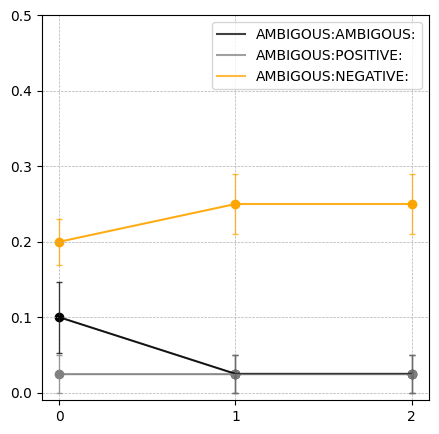

In [48]:
data_exp = convert_annotations_to_proportions(results_exp)

#lmer
lmer(data_exp, levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

ALL_DATA = {}
ALL_DATA[EXP[0]] = data_exp
plot(ALL_DATA, ax)

ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.010, 0.5)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend()

## Authors' Summaries / GPT-4 Evaluation

In [18]:
summaries = []
doc = Document(str(study_data / "output/Negativity.docx"))
for para in doc.paragraphs:
    if para.text:
        summaries.append(para.text)

In [64]:
# define the chain
connections = [
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5

# define the api and task
llm_model_execute = None
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})
task = TaskFactory.create(TaskType.AMBIGUITY, llm_model_execute, llm_model_evaluate)


simulations = []
for idx in range(n_simulations):
    all_nodes = setup_transmission_chain(connections, Node, task, idx)
    all_nodes[0][0].output = summaries[idx]
    all_nodes[1][0].output = summaries[idx + 5]
    all_nodes[2][0].output = summaries[idx + 2*5]
    simulations.append(all_nodes)
    

In [65]:
async def run_evaluation(all_nodes):
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation])

await asyncio.gather(*[run_evaluation(all_nodes) for all_nodes in simulations])

in:  2 (1, 0)
in:  0 (2, 0)
in:  2 (2, 0)
in:  4 (0, 0)
in:  1 (0, 0)
in:  2 (0, 0)
in:  3 (1, 0)
in:  3 (2, 0)
in:  4 (1, 0)
in:  1 (1, 0)
in:  3 (0, 0)
in:  0 (1, 0)
in:  0 (0, 0)
in:  4 (2, 0)
in:  1 (2, 0)


[None, None, None, None, None]

In [75]:
results = convert_summaries_to_annotations(simulations)
data = convert_annotations_to_proportions(results)

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_69041/1782083100.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_69041/1782083100.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_69041/1782083100.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

R[write to console]: boundary (singular) fit: see help('isSingular')



c("AMBIGOUS:AMBIGOUS:","AMBIGOUS:POSITIVE:","AMBIGOUS:NEGATIVE:")
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -62.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5943 -0.5927 -0.0365  0.6266  3.2205 

Random effects:
 Groups     Name        Variance  Std.Dev. 
 chain_id   (Intercept) 1.520e-03 3.899e-02
 chain_step (Intercept) 8.879e-19 9.423e-10
 Residual               1.011e-02 1.005e-01
Number of obs: 45, groups:  chain_id, 5; chain_step, 3

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                0.16667    0.03127 12.71996   5.330 0.000147 ***
contentAMBIGOUS:POSITIVE: -0.11667    0.03671 38.00000  -3.178 0.002943 ** 
contentAMBIGOUS:NEGATIVE:  0.06667    0.03671 38.00000   1.816 0.077244 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

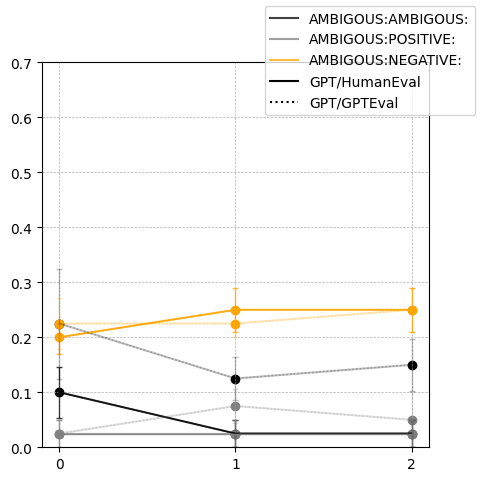

In [76]:
#lmer
lmer(data, lmer_levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

ALL_DATA = {}
ALL_DATA[EXP[0]] = data_exp
ALL_DATA[EXP[1]] = data
plot(ALL_DATA, ax)


ax.set_xticks([0, 1, 2])
ax.set_ylim(0, 0.7)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# legends
legends = []
extra_labels = []
for idx, key in enumerate(EXP):
    if key not in ALL_DATA:
        continue
    legends.append(plt.Line2D([0], [0], color='black', linestyle=LINESTYLES[idx], label=key))
    extra_labels.append(key)

handles, labels = ax.get_legend_handles_labels()

handles.extend(legends)
labels.extend(extra_labels)

# Create the legend with the combined handles and labels
fig.legend(handles, labels)

## New Summaries / GPT-4 Evaluation

In [82]:
# define the api and task
llm_model_execute = AzureOpenAIModel(AzureOpenAIModelType.GPT_3_5_TURBO, {})
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})

task = TaskFactory.create(TaskType.AMBIGUITY, llm_model_execute, llm_model_evaluate)

# define simulations asynchornously
async def run_simulation(connecitons, task, sim_idx):
    all_nodes = setup_transmission_chain(connections, Node, task, sim_idx)
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation ])
    return all_nodes

# define the chain
connections = [
    [[0]],
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5
completed = [run_simulation(connections, task, idx) for idx in range(n_simulations)]
simulations = await asyncio.gather(*completed)

for i, all_nodes in enumerate(simulations):
    print(f"Simulation {i + 1} completed.")

sent output to  [Sim:4 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:2 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:3 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:0 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:0 ID:(3, 0)	Incoming nodes: [(2, 0)]	Outgoing nodes: []]
sent output to  [Sim:1 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:1 ID:(3, 0)	Incoming nodes: [(2, 0)]	Outgoing nodes: []]
sent output to  [Sim:1 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:4 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:3 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  []
sent output to  [Sim:3 ID:(3, 0)	Incoming nodes: [(2, 0)]	Outgoing nodes: []]
sent output to  [Sim:0 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [

In [83]:
results = convert_summaries_to_annotations(simulations)
data2 = convert_annotations_to_proportions(results)

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_69041/890531322.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_69041/890531322.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_69041/890531322.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

R[write to console]: boundary (singular) fit: see help('isSingular')



c("AMBIGOUS:AMBIGOUS:","AMBIGOUS:POSITIVE:","AMBIGOUS:NEGATIVE:")
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -84.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7407 -0.6952 -0.2722  0.7007  2.4048 

Random effects:
 Groups     Name        Variance  Std.Dev. 
 chain_id   (Intercept) 4.274e-12 2.067e-06
 chain_step (Intercept) 1.295e-03 3.598e-02
 Residual               1.070e-02 1.034e-01
Number of obs: 60, groups:  chain_id, 5; chain_step, 4

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                0.14375    0.02930  8.53647   4.906 0.000981 ***
contentAMBIGOUS:POSITIVE: -0.08125    0.03271 53.99984  -2.484 0.016113 *  
contentAMBIGOUS:NEGATIVE: -0.04375    0.03271 53.99984  -1.338 0.186601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

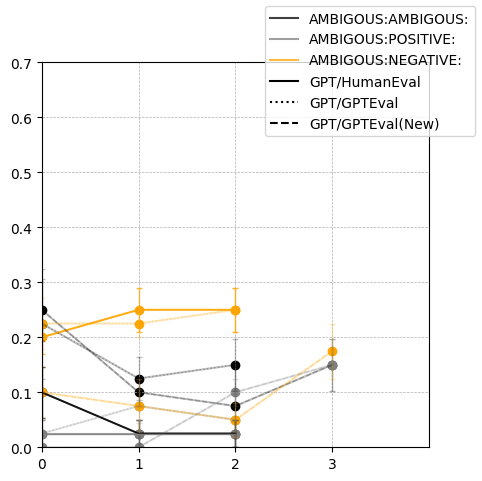

In [84]:
#lmer
lmer(data2)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)


ALL_DATA = {}
ALL_DATA[EXP[0]] = data_exp
ALL_DATA[EXP[1]] = data
ALL_DATA[EXP[2]] = data2

plot(ALL_DATA, ax)

# minor adjustments
ax.set_xticks(range(4))
ax.set_xlim(0, 4)
ax.set_ylim(0, 0.7)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# legends
# Add custom legend lines
legends = []
for idx, key in enumerate(EXP):
    if key not in ALL_DATA:
        continue
    legends.append(plt.Line2D([0], [0], color='black', linestyle=LINESTYLES[idx], label=key))

handles, labels = ax.get_legend_handles_labels()

handles.extend(legends)
labels.extend(EXP)

# Create the legend with the combined handles and labels
fig.legend(handles, labels)